# Benchmark chatGPT on repetitive sums dataset using function calling  

We want to evaluate openai models agains the repetitive sums task to measure its ability to perform computations of N terms.  

We use function calling to get a number output in JSON format.  

We managed to compare the performance of GPT4o, GPT4, and GPT3.5.  
This test cost around 3€.  

## install libs

In [1]:
!pip install openai
!pip install datasets

## inference function using tool calling  

We specify the template of the function to call so we can force chatGPT to answer in the numeric format that we can evaluate.  

We input a sum and want to get the result of this sum as an output.  

If we fail to parse a JSON response, we will consider that the result of the sum is 0.  

In [68]:
from openai import OpenAI
import json
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

# perform tool call to get the result of a sum
def get_sum_result(current_sum, curr_model="gpt-4o"):
    messages = [{"role": "user", "content": f"Record the answer to the following sum: {current_sum}"}]
    tools = [
        {
            "type": "function",
            "function": {
                "name": "record_answer",
                "description": "get the answer to the question",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "sum": {
                            "type": "string",
                            "description": "the input sum",
                        },
                        "result": {
                            "type": "integer",
                            "description": "the result of the sum"},
                    },
                    "required": ["sum, result"],
                },
            },
        }
    ]
    response = client.chat.completions.create(
        model=curr_model,
        messages=messages,
        tools=tools,
        tool_choice="auto",
    )
    response_message = response.choices[0].message
    tool_calls = response_message.tool_calls
    try:
        result = json.loads(tool_calls[0].function.arguments)['result']
        return result
    except Exception as e:
        return 0 #we return 0 if we fail to parse a json answer
    return result

# example call - defaults to gpt4o
sum_result = get_sum_result("1+1")
sum_result

2

## Make the sum dataset

In [32]:
import pandas as pd

addition_list = []
ones_list = []
for i in range(100):
  ones_list.append('1')
  addition_list.append({
      'sum' : '+'.join(ones_list),
      'result' : str(i+1)
      })

additions_df = pd.DataFrame(addition_list)

# we remove the first line that doesn't contain a sum (single one)
additions_df = additions_df[additions_df['result'] != '1']
additions_df.reset_index(drop=True, inplace=True)

additions_df.head()


,sum,result
0,1+1,2
1,1+1+1,3
2,1+1+1+1,4
3,1+1+1+1+1,5
4,1+1+1+1+1+1,6


## apply complete inference  

We make concurrent calls to the API to speedup the process.  

In [9]:
from functools import partial
import concurrent.futures
from tqdm.auto import tqdm

def perform_parallel_sums(sums_to_compute, model_name):
    # Number of parallel calls
    N = 20

    # Create a partial function with model_name argument
    partial_get_sum_result = partial(get_sum_result, curr_model=model_name)

    # Create a ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=N) as executor:
        # Wrap the executor.map with tqdm for progress bar
        inferred_sums = list(tqdm(executor.map(partial_get_sum_result, sums_to_compute), total=len(sums_to_compute)))

    return inferred_sums

# Example usage
model_name = "gpt-4o"
sums_to_compute = additions_df['sum'].tolist()
additions_df['inferred_result'] = perform_parallel_sums(sums_to_compute, model_name)

  0%|          | 0/99 [00:00<?, ?it/s]

## Analyze results

In [19]:
additions_df['is_correct'] = additions_df['result'].astype(int) == additions_df['inferred_result']
print(f"Average accuracy : {additions_df.is_correct.mean()*100:.02f}%")
print()

wrong_answers = additions_df[additions_df.is_correct == False].copy(deep=True)
wrong_answers['error_abs'] = abs(wrong_answers['result'].astype(int) - wrong_answers['inferred_result'])
wrong_answers['error_prop'] = wrong_answers['error_abs'] / wrong_answers['result'].astype(int)

print(f"Absolute error mean: {wrong_answers.error_abs.mean():.02f}")
print(f"Relative error mean: {wrong_answers.error_prop.mean()*100:.02f}%")
print()
print(f"Absolute error median: {wrong_answers.error_abs.median():.02f}")
print(f"Relative error median: {wrong_answers.error_prop.median()*100:.02f}%")
print()

Average accuracy : 69.70%

Absolute error mean: 4.53
Relative error mean: 5.50%

Absolute error median: 2.00
Relative error median: 3.64%



<ipython-input-11-d7399780e2ce>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


Text(0.5, 0, 'Sum')

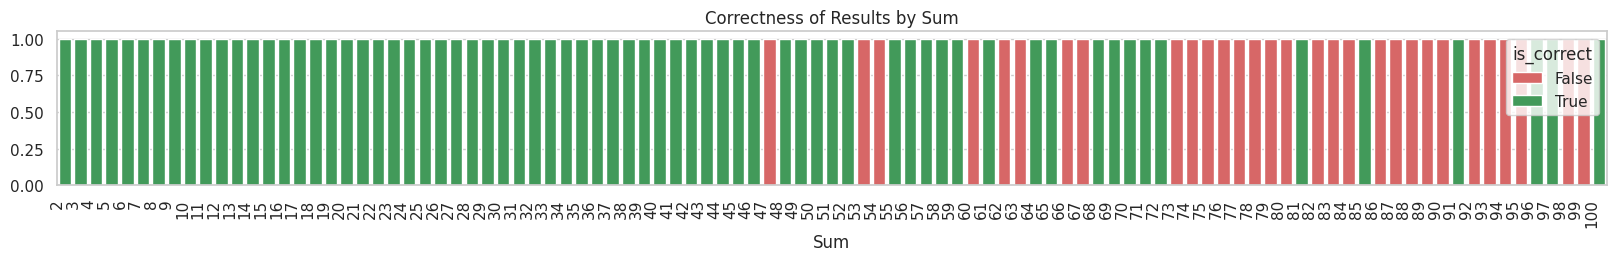

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Order the results
results = additions_df['result'].astype(int).unique()
results.sort()

# set the high and width
plt.figure(figsize=(20, 2))

# Create the barplot
g = sns.barplot(x="result", y=[1]*len(additions_df), data=additions_df, order=results, hue="is_correct", palette=["#EA5455", "#34A853"])

# pivot label
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

# Add title and labels
plt.title("Correctness of Results by Sum")
plt.xlabel("Sum")

## Compare models  

We compare performance on this benchmark among the 3 models that support function calling.  

In [63]:
def get_benchmark_df(df, models_to_test, number_of_samples=10):

  inferred_sums = []
  for curr_model in tqdm(models_to_test, desc='inferring on models'):
      inferred_sums.append(perform_parallel_sums(df['sum'].tolist()[:number_of_samples], curr_model))

  df_list = []
  df_list.append(df.head(number_of_samples))

  for inference_results, model_name in zip(inferred_sums, models_to_test):
    df_list.append(pd.DataFrame(inference_results, columns=[model_name]))
  return pd.concat(df_list, axis=1)

In [69]:
models_to_test = ['gpt-3.5-turbo', 'gpt-4', 'gpt-4o']
number_of_samples = 100

benchmark_df = get_benchmark_df(additions_df, models_to_test, number_of_samples)
benchmark_df.head()

inferring on models:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

,sum,result,gpt-3.5-turbo,gpt-4,gpt-4o
0,1+1,2,2,2,2
1,1+1+1,3,3,3,3
2,1+1+1+1,4,4,4,4
3,1+1+1+1+1,5,5,5,5
4,1+1+1+1+1+1,6,6,6,6


In [79]:
def analyze_model(df, model_name):
  df = df.copy(deep=True)

  # count parsing failures
  number_of_parsing_failures = len(df[df[model_name] == 0])

  # compute accuracy including JSON parse errors as bad answers
  df['is_correct'] = df['result'].astype(int) == df[model_name]
  mean_accuracy = df.is_correct.mean()*100

  # exclude parsing failures from stat count as "0" is not a significant result to measure
  df = df[df[model_name] != 0]

  # select the failed results to compute error stats
  wrong_answers = df[df.is_correct == False].copy(deep=True)


  if len(wrong_answers) == 0:
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : 0,
        'error_median' : 0,
        'error_std' : 0,
        'error_min' : 0,
        'error_max' : 0,
        'parsing_failure_count' : number_of_parsing_failures
    }
  else:
    wrong_answers['error_abs'] = abs(wrong_answers['result'].astype(int) - wrong_answers[model_name])
    wrong_answers['error_prop'] = wrong_answers['error_abs'] / wrong_answers['result'].astype(int)
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : wrong_answers['error_abs'].mean(),
        'error_median' : wrong_answers['error_abs'].median(),
        'error_std' : wrong_answers['error_abs'].std(),
        'error_min' : wrong_answers['error_abs'].min(),
        'error_max' : wrong_answers['error_abs'].max(),
        'parsing_failure_count' : number_of_parsing_failures
    }

def get_stats_recap(benchmark_df, models_to_test):
  results = []
  for model_name in models_to_test:
    results.append(analyze_model(benchmark_df, model_name))

  return pd.DataFrame(results)


get_stats_recap(benchmark_df, models_to_test)

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,gpt-3.5-turbo,33.333333,6.423729,5.0,4.966104,1,19,7
1,gpt-4,40.404040,6.155172,5.0,4.972915,1,28,1
2,gpt-4o,67.676768,3.593750,2.0,3.088578,1,11,0


<ipython-input-71-0fcd765fcb44>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


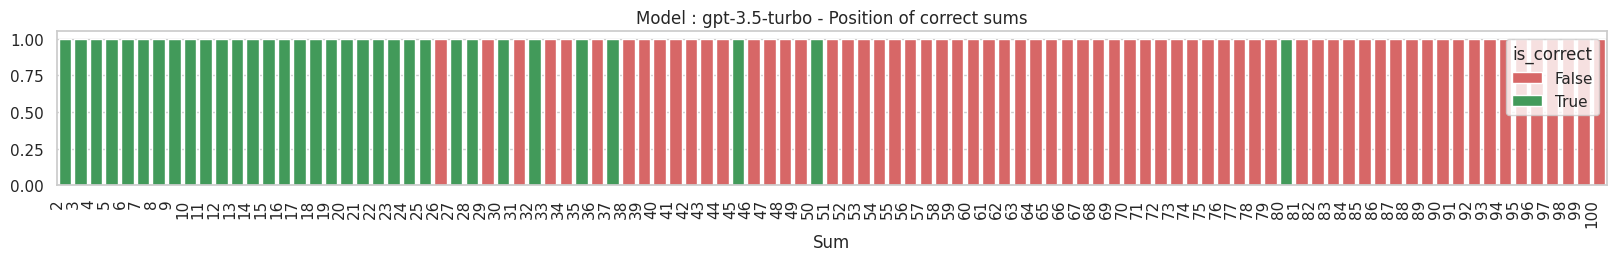

<ipython-input-71-0fcd765fcb44>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


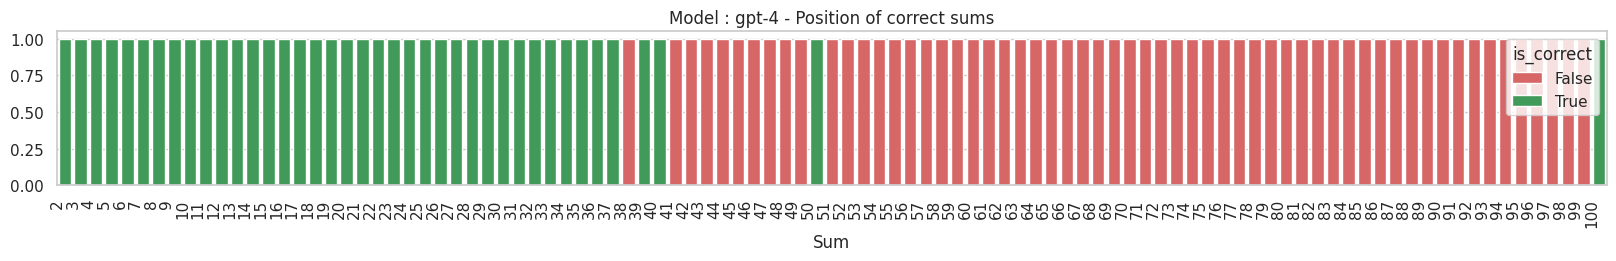

<ipython-input-71-0fcd765fcb44>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


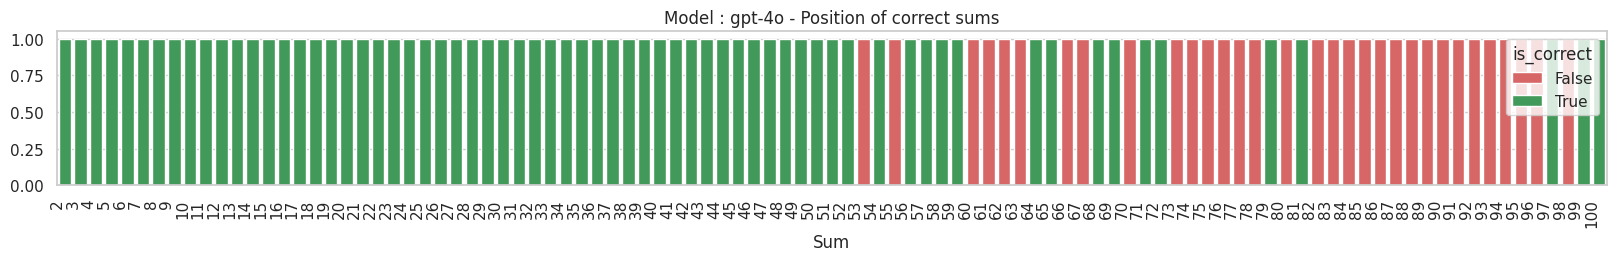

In [71]:
def show_model_results(df, model_name):
  df['is_correct'] = df['result'].astype(int) == df[model_name]

  sns.set_theme(style="whitegrid")

  # Order the results
  results = df['result'].astype(int).unique()
  results.sort()

  # set the high and width
  plt.figure(figsize=(20, 2))

  # Create the barplot
  g = sns.barplot(x="result", y=[1]*len(df), data=df, order=results, hue="is_correct", palette={False:"#EA5455", True:"#34A853"})

  # pivot label
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

  # Add title and labels
  plt.title(f"Model : {model_name} - Position of correct sums")
  plt.xlabel("Sum")
  plt.show()

for curr_model in models_to_test:
  show_model_results(benchmark_df, curr_model)